# Multi-planetary search

In this notebook, we use `nuance` to search for the transiting exoplanets with the following parameters:

In [1]:
truth = [
    {"t0": 0.5, "D": 0.03, "P": 1.8, "depth": 3e-3},
    {"t0": 0.2, "D": 0.03, "P": 0.8, "depth": 1e-3},
]

where $t_0$ is the transit epoch, $D$ its duration and $P$ its period (all in days). Let generate this signal together with correlated noise

/Users/lgarcia/code/dev/nuance/nuance/nuance.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


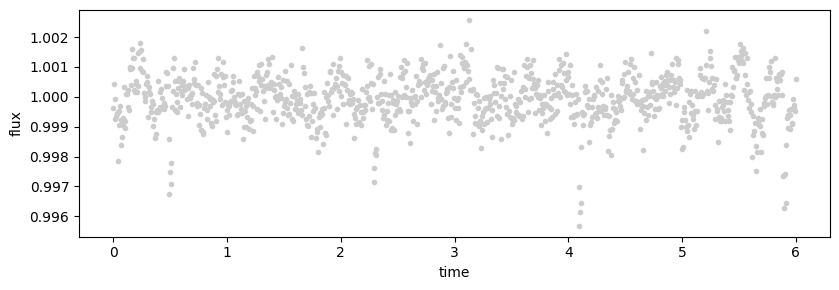

In [2]:
import jax

jax.config.update("jax_enable_x64", True)

import tinygp
import numpy as np
import matplotlib.pyplot as plt
from nuance.utils import periodic_transit

# measurements
time = np.linspace(0, 6, 1000)
error = 0.0005

transits = [p["depth"] * periodic_transit(time, p["t0"], p["D"], p["P"]) for p in truth]
diff_transit_flux = np.sum(transits, 0) + 1.0

# GP
kernel = tinygp.kernels.quasisep.SHO(
    np.pi / (truth[1]["D"] * 5), 8.0, truth[1]["depth"] / 2
)
gp = tinygp.GaussianProcess(kernel, time, diag=error**2, mean=0.0)
flux = diff_transit_flux + gp.sample(jax.random.PRNGKey(40))

plt.figure(None, (8.5, 3))
plt.plot(time, flux, ".", c="0.8")
plt.ylabel("flux")
plt.xlabel("time")

plt.tight_layout()

## The *linear search*

We start by instantiating a [Nuance](nuance.Nuance) object, and perform the *linear search* over all times (considered as potential transit epochs) and on a wide range of durations.

In [3]:
from nuance import Nuance, utils

nu = Nuance(time, flux, gp=gp)

t0s = time.copy()
Ds = np.linspace(0.01, 0.2, 15)
nu.linear_search(t0s, Ds)

  0%|          | 0/84 [00:00<?, ?it/s]

```{note}
Notice how we reused the same kernel used to generate the data. In practice, a kernel need to be properly set and its hyper-parameters optimized. See the [GP optimization tutorial](gp.ipynb)
```

Whatever the number of planets we will look for, this step needs to be done only once.

## The *periodic search*
### First planet

We can now perform the periodic search and plot the SNR periodogram

  0%|          | 0/4000 [00:00<?, ?it/s]

epoch: 0.504
duration: 0.024
period: 1.798


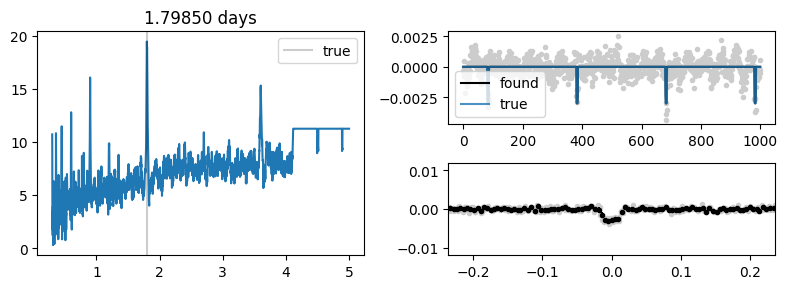

In [4]:
import matplotlib.pyplot as plt
from nuance.utils import plot_search

periods = np.linspace(0.3, 5, 4000)
search = nu.periodic_search(periods)

t0, D, P = search.best

# plotting
plt.figure(None, (8, 3))
plot_search(nu, search)
plt.tight_layout()

print(
    "\n".join(
        [f"{n}: {v:.3f}" for n, v in zip(["epoch", "duration", "period"], [t0, D, P])]
    )
)

# over plotting real values
from nuance.utils import periodic_transit

main, raw, detrended = plt.gcf().axes
true = truth[0]
main.axvline(true["P"], c="k", alpha=0.2, label="true")
main.legend()
raw.plot(
    true["depth"] * periodic_transit(nu.time, true["t0"], true["D"], P=true["P"]),
    c="C0",
    alpha=0.8,
    label="true",
)
raw.legend()

This corresponds to the first transit signal injected.

### Second search

To look for a second planetary candidate, we can mask the current candidate with

In [5]:
nu2 = nu.mask_model(*search.best)

AttributeError: 'Nuance' object has no attribute 'mask'

and perform the second *periodic search*

```{note}
Again, we only have to perform another *periodic search*, reusing the products of the *linear search* without loss of sensitivity
``` 

In [ ]:
search2 = nu2.periodic_search(periods)

t0, D, P = search.best

# plotting
plt.figure(None, (8, 3))
plot_search(nu2, search2)
plt.tight_layout()

print(
    "\n".join(
        [f"{n}: {v:.3f}" for n, v in zip(["epoch", "duration", "period"], [t0, D, P])]
    )
)

# over plotting real values
from nuance.utils import periodic_transit

main, raw, detrended = plt.gcf().axes
true = truth[1]
main.axvline(true["P"], c="k", alpha=0.2, label="true")
main.legend()
raw.plot(
    true["depth"] * periodic_transit(nu2.time, true["t0"], true["D"], P=true["P"]),
    c="C0",
    alpha=0.8,
    label="true",
)
raw.legend()

which is the second planetary transit injected.

```{note}
Notice how we use `nu2` in the last cell, where previous transits are clearly masked from `nu2.flux`. By masking the first planet, we also mask the likelihoods values matching its parameters. This is how multiple searches can be performed without re-running the *linear search*
```